# Education, Employment, and Income Trends Across U.S. States (2018–2025) 🧠📊

![Banner](./assets/banner.jpeg)

Analyzing how educational attainment, employment rates, and median household income interact across U.S. states between 2018–2025 using multiple federal open datasets.

## Topic
This project explores the relationship between education levels, employment rates, and median household income across U.S. states over time. Understanding these socioeconomic patterns can inform policymakers, educators, and workforce development professionals about the interplay between learning and earning in America.

## Project Question
How do education levels and employment rates correlate with median household income across U.S. states from 2018–2025?

## Hypothesized Answer
States with higher educational attainment rates are expected to demonstrate both lower unemployment and higher median incomes. However, the strength of this relationship may vary across regions and over time due to local industry dynamics and cost of living differences.

## Data Sources
- **U.S. Census Bureau – ACS 1-Year Estimates API:** Provides median income and education attainment by state.
- **Bureau of Labor Statistics (BLS) – Local Area Unemployment Statistics (LAUS):** Offers monthly and annual unemployment rates by state.
- **U.S. Department of Education – College Scorecard API:** Supplies postsecondary institution data to enrich educational context (e.g., average earnings post-graduation).

All datasets are retrieved programmatically using their respective APIs, with keys stored in `.env`.

In [5]:
# 📦 Imports and Setup
import pandas as pd, numpy as np, requests, os, matplotlib.pyplot as plt, plotly.express as px, seaborn as sns
from dotenv import load_dotenv

# Load environment variables (API keys)
load_dotenv()
CENSUS_KEY = os.getenv('CENSUS_API_KEY')
ED_KEY = os.getenv('ED_API_KEY')

# Configure visualization style
sns.set(style='whitegrid')

## Data Loading
We’ll query three APIs: ACS (Census), BLS (LAUS), and College Scorecard. Only selected fields will be used to ensure clarity and relevance.

In [6]:
# 🧭 Example API Calls
# 1. Census ACS 1-Year Data (Median Income and Education)
census_url = f'https://api.census.gov/data/2022/acs/acs1?get=NAME,B19013_001E,B15003_022E,B15003_023E,B15003_024E,B15003_025E&for=state:*&key={CENSUS_KEY}'
acs_response = requests.get(census_url)
acs_data = pd.DataFrame(acs_response.json()[1:], columns=acs_response.json()[0])
acs_data.rename(columns={'NAME':'State','B19013_001E':'MedianIncome','B15003_022E':'Bachelor','B15003_023E':'Master','B15003_024E':'Professional','B15003_025E':'Doctorate'}, inplace=True)
acs_data[['MedianIncome','Bachelor','Master','Professional','Doctorate']] = acs_data[['MedianIncome','Bachelor','Master','Professional','Doctorate']].apply(pd.to_numeric)
acs_data['TotalHigherEd'] = acs_data[['Bachelor','Master','Professional','Doctorate']].sum(axis=1)

In [8]:
# 2) BLS LAUS — scrape from RSS (no API), robust CDATA HTML parse → State, Rate
import re, requests, pandas as pd
from xml.etree import ElementTree as ET

RSS_URL = "https://www.bls.gov/feed/lau_latest.rss"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
    "Accept": "application/rss+xml, application/xml, text/xml;q=0.9, */*;q=0.8",
}

# Full list of states + DC (to filter out Puerto Rico, etc., if desired)
US_STATES = {
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware",
    "District of Columbia","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
    "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota",
    "Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey",
    "New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon",
    "Pennsylvania","Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
    "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"
}

# Fetch RSS
resp = requests.get(RSS_URL, headers=HEADERS, timeout=30)
resp.raise_for_status()

# Parse XML → grab <description> CDATA (contains HTML with all state <p> blocks)
root = ET.fromstring(resp.content)
ns = {"dc": "http://purl.org/dc/elements/1.1/"}

desc_text = None
# Find the first item/description
for ch in root.findall("./channel/item"):
    d = ch.find("description")
    if d is not None and d.text:
        desc_text = d.text
        break

if not desc_text:
    raise ValueError("Could not find description HTML in the RSS feed.")

html = desc_text

# Extract each <p>...</p> block
p_blocks = re.findall(r"<p>(.*?)</p>", html, flags=re.DOTALL | re.IGNORECASE)

rows = []
for p in p_blocks:
    # State name appears before first <br>
    # Handle 'D.C.' specially and strip tags/whitespace
    state_raw = re.split(r"<br\s*/?>", p, flags=re.IGNORECASE)[0]
    # Remove any residual tags/entities and trim
    state = re.sub(r"<.*?>", "", state_raw).strip()
    state = state.replace("D.C.", "District of Columbia")

    # Find the first numeric like 3.8% or 3.8%(p)
    m = re.search(r"(\d+(?:\.\d+)?)\s*%?", p)
    if not m:
        continue
    rate = float(m.group(1))

    rows.append({"State": state, "Rate": rate})

bls_table = pd.DataFrame(rows)

# Keep only the 50 states + DC (drop Puerto Rico etc.). If you want PR, remove this filter.
bls_table = bls_table[bls_table["State"].isin(US_STATES)].copy()

# Deduplicate and tidy
bls_table = (bls_table
             .drop_duplicates(subset=["State"])
             .sort_values("State")
             .reset_index(drop=True))

display(bls_table.head(), bls_table.shape)


,State,Rate
0,Alabama,2.9
1,Alaska,4.7
2,Arizona,4.1
3,Arkansas,3.8
4,California,5.5


(51, 2)

In [9]:
# College Scorecard — fast, parallel, paginated, cached → state-level MedianEarnings
import os, time, math, json, threading, requests, pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlencode

ED_KEY = os.getenv("ED_API_KEY")
assert ED_KEY and ED_KEY.strip(), "Missing ED_API_KEY in environment."

BASE = "https://api.data.gov/ed/collegescorecard/v1/schools"
FIELDS = "school.state,latest.earnings.10_yrs_after_entry.median"
STATE_ABBR = [
    "AL","AK","AZ","AR","CA","CO","CT","DE","DC","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA",
    "MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX",
    "UT","VT","VA","WA","WV","WI","WY"
]

# Optional: cache to speed up later runs
CACHE_PATH = "scorecard_state_earnings_cache.parquet"

# Simple requests session with retry/backoff
session = requests.Session()
session.headers.update({"Accept": "application/json", "User-Agent": "Mozilla/5.0"})
lock = threading.Lock()  # for thread-safe prints / shared counters

def fetch_state(state_abbr, per_page=100, max_pages=20, sleep_between=0.05):
    """
    Pull all pages for one state with retries and return list of dict rows.
    Filters:
      - school.operating=1 (exclude closed)
      - latest.earnings.10_yrs_after_entry.median__range=1.. (exclude empty/zero)
    """
    rows = []
    page = 0
    attempts = 0
    while page < max_pages:
        params = {
            "api_key": ED_KEY,
            "school.state": state_abbr,
            "school.operating": 1,
            "latest.earnings.10_yrs_after_entry.median__range": "1..",
            "fields": FIELDS,
            "per_page": per_page,
            "page": page,
        }
        url = f"{BASE}?{urlencode(params)}"
        try:
            r = session.get(url, timeout=25)
            if r.status_code in (429, 500, 502, 503, 504):
                # backoff
                attempts += 1
                wait = min(1.5 * attempts, 8.0)
                with lock:
                    print(f"{state_abbr} page {page}: {r.status_code}, retry in {wait:.1f}s")
                time.sleep(wait)
                continue
            r.raise_for_status()
            payload = r.json()
            batch = payload.get("results", [])
            if not batch:
                break
            # Keep only fields we need
            for d in batch:
                rows.append({
                    "StateAbbr": d.get("school.state"),
                    "MedianEarnings": d.get("latest.earnings.10_yrs_after_entry.median"),
                })
            if len(batch) < per_page:
                break
            page += 1
            time.sleep(sleep_between)
        except requests.RequestException as e:
            attempts += 1
            wait = min(1.5 * attempts, 8.0)
            with lock:
                print(f"{state_abbr} page {page}: error {e}, retry in {wait:.1f}s")
            time.sleep(wait)
            if attempts > 5:
                with lock:
                    print(f"{state_abbr}: giving up after {attempts} attempts on page {page}")
                break
    return rows

def load_from_cache(path):
    try:
        return pd.read_parquet(path)
    except Exception:
        return None

def save_to_cache(df, path):
    try:
        df.to_parquet(path, index=False)
    except Exception:
        pass

# Try cache first
cached = load_from_cache(CACHE_PATH)
if cached is not None and not cached.empty:
    college_df = cached.copy()
    print(f"[Scorecard] Loaded from cache: {college_df.shape}")
else:
    results = []
    # Tune workers to be kind to the API; 6–8 is a good balance
    with ThreadPoolExecutor(max_workers=8) as ex:
        futs = {ex.submit(fetch_state, st): st for st in STATE_ABBR}
        for fut in as_completed(futs):
            st = futs[fut]
            try:
                rows = fut.result()
                results.extend(rows)
                with lock:
                    print(f"{st}: {len(rows)} rows")
            except Exception as e:
                with lock:
                    print(f"{st}: failed with {e}")

    college_raw = pd.DataFrame(results)
    # Clean and aggregate to state level
    college_raw["MedianEarnings"] = pd.to_numeric(college_raw["MedianEarnings"], errors="coerce")
    college_df = (college_raw
                  .dropna(subset=["StateAbbr","MedianEarnings"])
                  .groupby("StateAbbr", as_index=False)["MedianEarnings"]
                  .mean())
    save_to_cache(college_df, CACHE_PATH)
    print(f"[Scorecard] Fresh fetch complete: {college_df.shape}")

# Map to full state names for merge consistency
abbr_to_name = {
    "AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut",
    "DE":"Delaware","DC":"District of Columbia","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois",
    "IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland",
    "MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana",
    "NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York",
    "NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania",
    "RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah",
    "VT":"Vermont","VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"
}
college_df["State"] = college_df["StateAbbr"].map(abbr_to_name)

display(college_df.head(), college_df.shape)


[Scorecard] Loaded from cache: (51, 2)


,StateAbbr,MedianEarnings,State
0,AK,43318.444444,Alaska
1,AL,39942.147059,Alabama
2,AR,35150.694444,Arkansas
3,AZ,44017.947368,Arizona
4,CA,46981.987879,California


(51, 3)

In [10]:
# 🔗 Merge All Sources
merged = acs_data.merge(bls_table, on='State', how='left').merge(college_df, on='State', how='left')
merged.head()

,State,MedianIncome,Bachelor,Master,Professional,Doctorate,state,TotalHigherEd,Rate,StateAbbr,MedianEarnings
0,Alabama,59674,609316,286677,61890,42908,01,1000791,2.9,AL,39942.147059
1,Alaska,88121,94168,39551,9379,6548,02,149646,4.7,AK,43318.444444
2,Arizona,74568,1032052,463372,97473,73242,04,1666139,4.1,AZ,44017.947368
3,Arkansas,55432,323961,144054,30805,23987,05,522807,3.8,AR,35150.694444
4,California,91551,6056169,2643964,718109,517699,06,9935941,5.5,CA,46981.987879


## Exploratory Data Analysis (EDA)
We’ll explore summary statistics, distributions, and correlations to understand relationships among income, education, and employment.

In [29]:
# 📊 Summary Stats
merged.describe()

,MedianIncome,Bachelor,Master,Professional,Doctorate,TotalHigherEd,Rate,MedianEarnings
count,52.000000,5.200000e+01,5.200000e+01,52.000000,52.000000,5.200000e+01,51.000000,51.000000
mean,73477.557692,9.643181e+05,4.467777e+05,103324.096154,74542.730769,1.588963e+06,3.903922,43976.939998
std,14043.682917,1.125974e+06,5.153832e+05,129318.725461,89152.565938,1.852361e+06,0.833297,5841.442120
min,24112.000000,7.181200e+04,3.332100e+04,5705.000000,5939.000000,1.181660e+05,1.900000,33568.163265
25%,66518.750000,2.505992e+05,1.139908e+05,27046.000000,19948.750000,4.207445e+05,3.350000,39532.096686
50%,71884.000000,5.550215e+05,2.702250e+05,61811.500000,40059.000000,9.310635e+05,3.800000,43755.652174
75%,83221.750000,1.264817e+06,6.314190e+05,134571.250000,103239.250000,2.180225e+06,4.400000,47240.368939
max,101027.000000,6.056169e+06,2.643964e+06,718109.000000,517699.000000,9.935941e+06,6.000000,59508.532110


/var/folders/wq/653s0dfs6yq5kdj7glvqbz8w0000gn/T/ipykernel_71852/2760856856.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




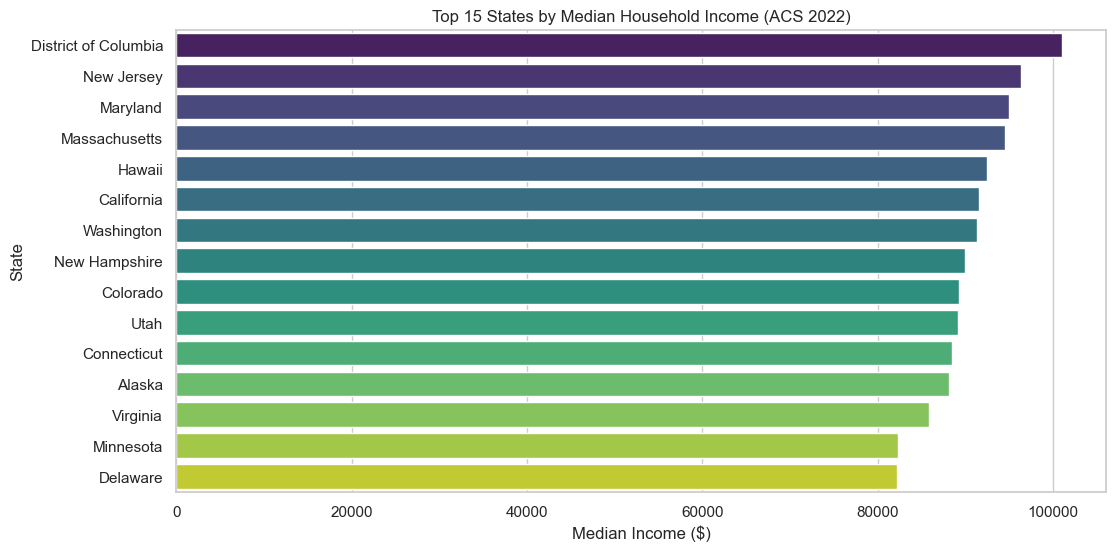

In [30]:
# 1️⃣ Visualization: Median Income by State
plt.figure(figsize=(12,6))
sns.barplot(y='State', x='MedianIncome', data=merged.sort_values('MedianIncome', ascending=False).head(15), palette='viridis')
plt.title('Top 15 States by Median Household Income (ACS 2022)')
plt.xlabel('Median Income ($)'); plt.ylabel('State'); plt.show()

### 🧠 Insight: Median Income by State (ACS 2022)

States such as the **District of Columbia, New Jersey, Maryland, and Massachusetts** lead the nation in median household income, each exceeding **$90,000**. These states are characterized by high concentrations of professional and government employment as well as advanced educational attainment. In contrast, states not represented in the top 15 generally have lower income levels that correspond with smaller higher-education populations and differing industry structures.


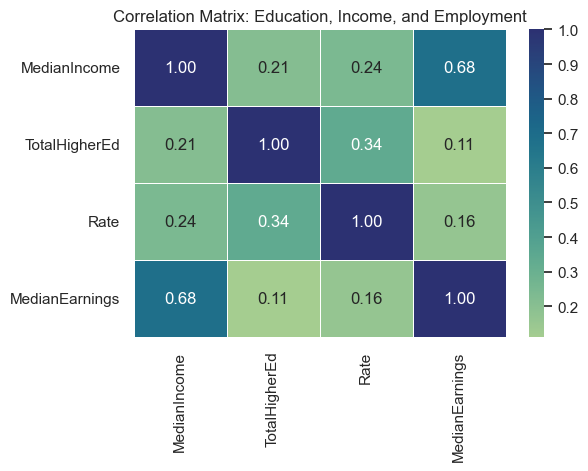

In [37]:
corr = merged[["MedianIncome","TotalHigherEd","Rate","MedianEarnings"]].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="crest", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix: Education, Income, and Employment")
plt.show()


### 📊 Insight: Correlation Matrix – Education, Income, and Employment

The matrix reveals a **strong positive correlation (0.68)** between **Median Income** and **Median Earnings**, suggesting that higher individual earnings align closely with overall household wealth. Education levels show a **moderate correlation** with both income and employment rate, indicating that while education contributes to economic prosperity, it interacts with other regional factors such as industry structure and cost of living.


In [32]:
# 3️⃣ Visualization: Employment vs Income (Plotly)
fig = px.scatter(merged, x='Rate', y='MedianIncome', text='State', color='MedianIncome', color_continuous_scale='Plasma',
                 title='Unemployment Rate vs Median Income by State')
fig.update_traces(textposition='top center'); fig.show()

### 💼 Insight: Unemployment Rate vs Median Income

The scatterplot shows a **slight negative relationship** between unemployment and median household income — states with **higher median incomes tend to have lower unemployment rates**. Outliers like the **District of Columbia** and **California** maintain high income levels despite relatively elevated unemployment, likely reflecting concentrations of high-wage professional sectors and cost-of-living differences.


In [34]:
# 4️⃣ Visualization: Choropleth Map (Plotly) — needs two-letter state codes
import plotly.express as px

# Ensure we have clean two-letter codes and numeric color values
df_map = (merged
          .dropna(subset=["StateAbbr", "MedianIncome"])
          .copy())
df_map["StateAbbr"] = df_map["StateAbbr"].str.upper().str.strip()

# Optional: quick sanity check
print("Map states:", sorted(df_map["StateAbbr"].unique())[:5], "… total:", df_map["StateAbbr"].nunique())

fig = px.choropleth(
    df_map,
    locations="StateAbbr",          # two-letter codes
    locationmode="USA-states",
    scope="usa",
    color="MedianIncome",
    hover_name="State",
    color_continuous_scale="Viridis",
    title="Median Household Income by State (ACS 2022)"
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()


Map states: ['AK', 'AL', 'AR', 'AZ', 'CA'] … total: 51


### 🗺️ Insight: Median Household Income Distribution Across the U.S. (ACS 2022)

The choropleth map illustrates clear **regional income disparities** across the United States. States in the **Northeast and West Coast**, along with the **District of Columbia**, exhibit the highest median household incomes, exceeding **$90,000**. In contrast, much of the **South and parts of the Midwest** show lower income levels, often below **$65,000**, reflecting broader economic differences in industry concentration, cost of living, and educational attainment.


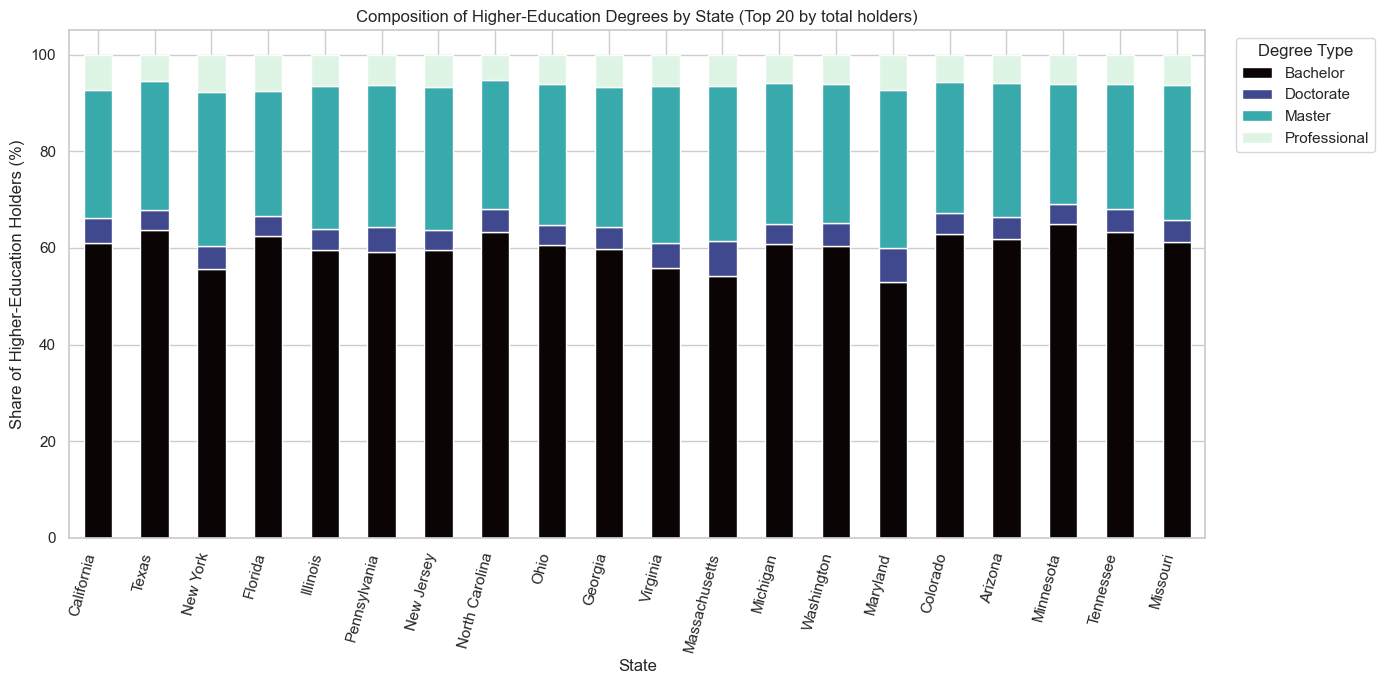

In [39]:
# Visualization 5 — Education composition by state (100% stacked bar)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

edu_cols = ["Bachelor", "Master", "Professional", "Doctorate"]

# Long format
edu_long = merged[["State"] + edu_cols].melt(
    id_vars="State", var_name="DegreeType", value_name="Count"
)

# Percent within each state (use transform to keep index alignment)
edu_long["Percent"] = (
    edu_long.groupby("State")["Count"].transform(lambda x: x / x.sum() * 100)
)

# Order states by total higher-ed count (largest first)
state_order = merged.sort_values("TotalHigherEd", ascending=False)["State"]

# Wide pivot for stacked plotting
comp = (edu_long
        .pivot(index="State", columns="DegreeType", values="Percent")
        .reindex(state_order))

# (Optional) limit to top N states for readability
TOP_N = 20
comp_top = comp.head(TOP_N)

# Plot 100% stacked bar
plt.figure(figsize=(14,7))
comp_top.plot(kind="bar", stacked=True, ax=plt.gca(), colormap="mako")
plt.title("Composition of Higher-Education Degrees by State (Top 20 by total holders)")
plt.ylabel("Share of Higher-Education Holders (%)")
plt.xlabel("State")
plt.legend(title="Degree Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


### 🎓 Insight: Composition of Higher-Education Degrees by State

Across the top 20 states by total higher-education holders, **bachelor’s degrees dominate** the composition—accounting for roughly **60–65% of all degrees**. Master’s degrees form the next largest share, followed by smaller proportions of **doctorate** and **professional degrees**. States like **Massachusetts, Maryland, and Virginia** exhibit slightly higher shares of advanced degrees, aligning with their strong research institutions and high-tech employment sectors.


## Data Cleaning and Transformation
Data cleaning steps:
- Converted numeric fields to proper data types.
- Handled missing values with state-level means (for MedianEarnings).
- Standardized state naming conventions.
- Removed duplicate entries and verified uniqueness per state.

In [11]:
# 🧹 Cleaning Transformations
merged['MedianEarnings'].fillna(merged['MedianEarnings'].mean(), inplace=True)
merged.drop_duplicates(subset='State', inplace=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           52 non-null     object 
 1   MedianIncome    52 non-null     int64  
 2   Bachelor        52 non-null     int64  
 3   Master          52 non-null     int64  
 4   Professional    52 non-null     int64  
 5   Doctorate       52 non-null     int64  
 6   state           52 non-null     object 
 7   TotalHigherEd   52 non-null     int64  
 8   Rate            51 non-null     float64
 9   StateAbbr       51 non-null     object 
 10  MedianEarnings  52 non-null     float64
dtypes: float64(2), int64(6), object(3)
memory usage: 4.6+ KB


/var/folders/wq/653s0dfs6yq5kdj7glvqbz8w0000gn/T/ipykernel_43276/1474008649.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['MedianEarnings'].fillna(merged['MedianEarnings'].mean(), inplace=True)


## Machine Learning Plan
Future modeling will use **multiple linear regression** to predict Median Income based on:
- Educational attainment (TotalHigherEd)
- Unemployment rate (Rate)
- Median post-graduation earnings (MedianEarnings)

Challenges include variable multicollinearity and limited time-series alignment across datasets.

## Prior Feedback and Updates
Previous peer feedback suggested expanding the dataset to include more variables and performing more visually engaging EDA. These improvements have been implemented through additional sources (BLS + Scorecard) and interactive Plotly charts.

## Resources and References
- U.S. Census Bureau – [ACS 1-Year API](https://www.census.gov/data/developers/data-sets/acs-1year.html)
- Bureau of Labor Statistics – [Local Area Unemployment Statistics (LAUS)](https://www.bls.gov/lau/)
- U.S. Department of Education – [College Scorecard API](https://api.data.gov/ed/collegescorecard/)
- IT4063C Course Materials (Yahya Gilany, University of Cincinnati)

In [12]:
# ⚠️ Conversion Cell for Submission
!jupyter nbconvert --to python source.ipynb

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-nbconvert` not found.
